In [3]:
# prompt: connect drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

SEED = 42

In [5]:
with open('/content/drive/MyDrive/diplomatiki/code/chatbot/intents_en.json') as file:
  intents = json.load(file)

In [6]:
patterns = []
tags = []

for intent in intents['intents']:
  tag = intent['tag']
  for pattern in intent['patterns']:
    tags.append(tag)
    patterns.append(pattern)

df = pd.DataFrame({'Pattern': patterns, 'Tag': tags})

In [7]:
df.head()

,Pattern,Tag
0,for how many courses can i register during the...,getAvailableCoursesByExamPeriod
1,for how many courses am i required to register...,getAvailableCoursesByExamPeriod
2,up to how many courses can i register for in j...,getAvailableCoursesByExamPeriod
3,up to how many courses can i register for in j...,getAvailableCoursesByExamPeriod
4,good morning which courses am i allowed to reg...,getAvailableCoursesByExamPeriod


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2361 entries, 0 to 2360
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  2361 non-null   object
 1   Tag      2361 non-null   object
dtypes: object(2)
memory usage: 37.0+ KB


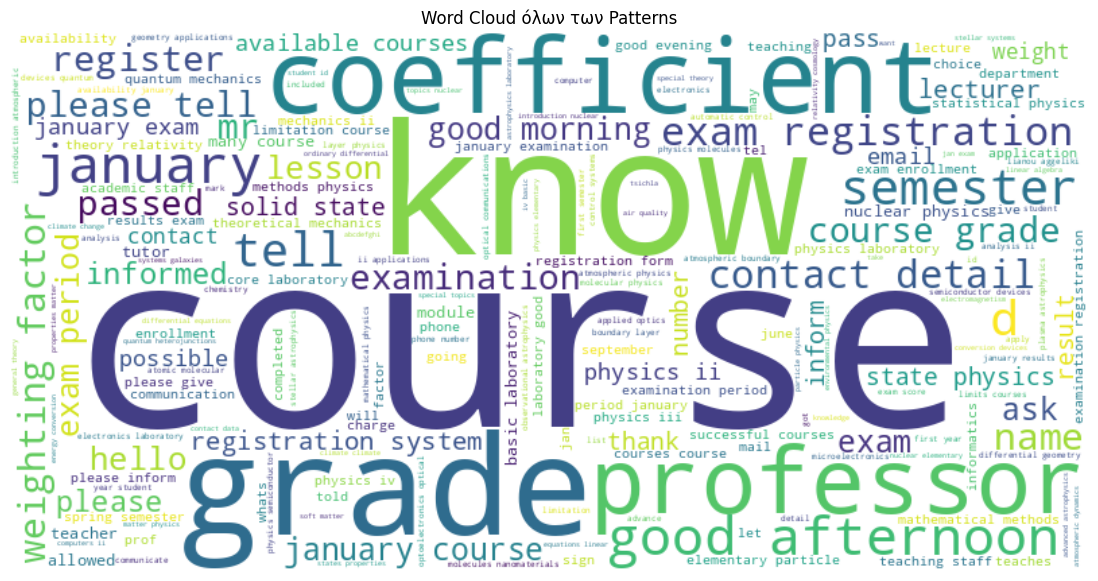

In [9]:
from wordcloud import WordCloud

text = " ".join(pattern for pattern in df['Pattern'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud όλων των Patterns')
plt.show()


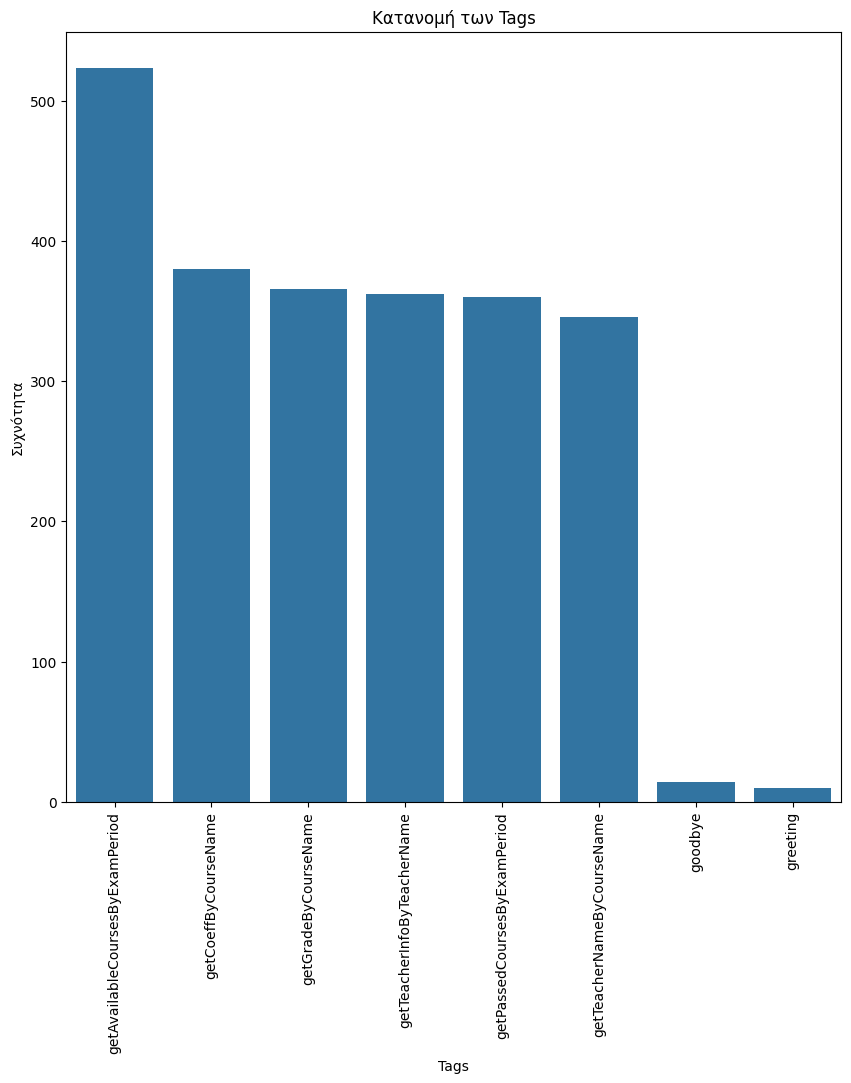

In [10]:
# Visualize the distribution of Classes
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(x='Tag', data=df, ax=ax, order=df['Tag'].value_counts().index)
plt.xticks(rotation=90)
ax.set_xlabel('Tags')
ax.set_ylabel('Συχνότητα')
ax.set_title('Κατανομή των Tags')
plt.show()



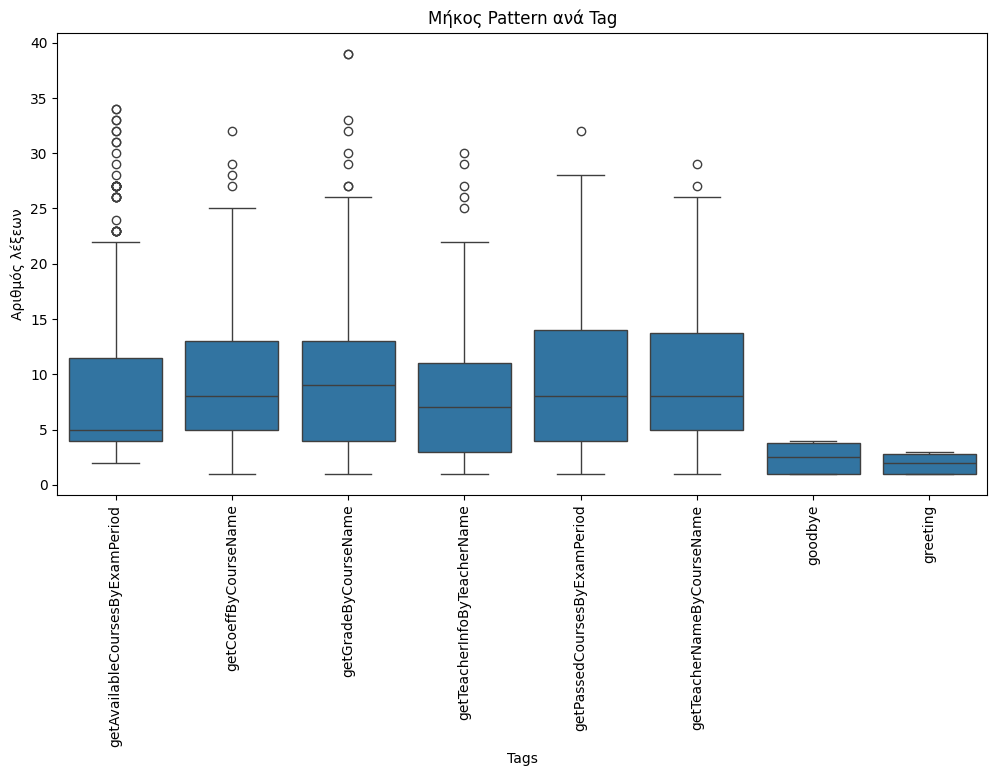

In [11]:
df['Pattern_Length'] = df['Pattern'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12,6))
sns.boxplot(x='Tag', y='Pattern_Length', data=df, order=df['Tag'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Μήκος Pattern ανά Tag')
plt.xlabel('Tags')
plt.ylabel('Αριθμός λέξεων')
plt.show()



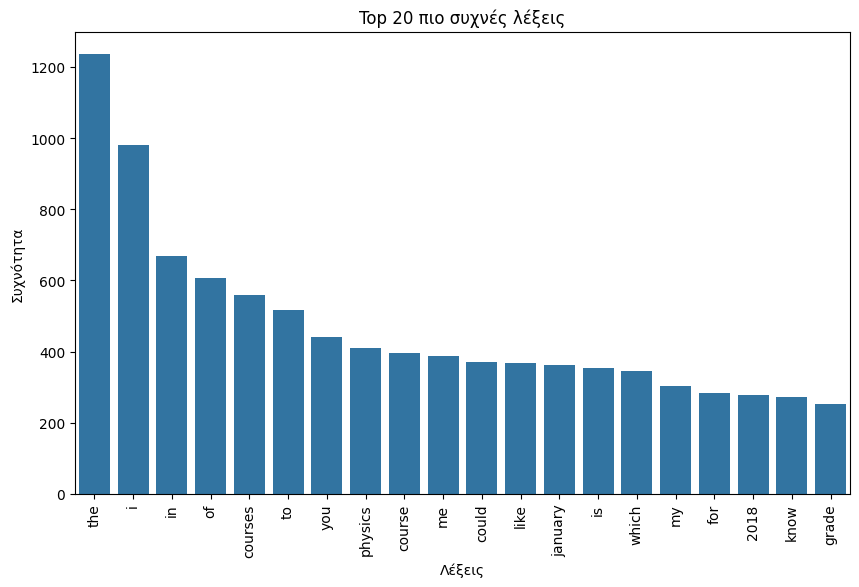

In [12]:
from collections import Counter

words = " ".join(df['Pattern']).split()
word_counts = Counter(words)
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10,6))
sns.barplot(x=list(words), y=list(counts))
plt.title('Top 20 πιο συχνές λέξεις')
plt.xlabel('Λέξεις')
plt.ylabel('Συχνότητα')
plt.xticks(rotation=90)
plt.show()


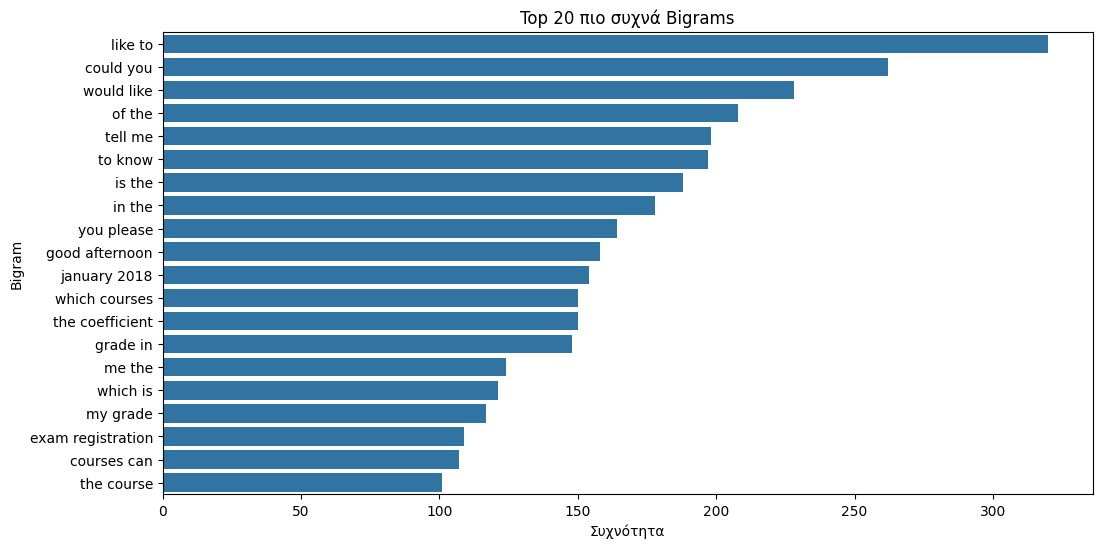

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Όλα τα patterns σε μία λίστα
corpus = df['Pattern'].tolist()

# Bigrams
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2))
X_bigram = vectorizer_bigram.fit_transform(corpus)
bigram_sum = X_bigram.sum(axis=0)
bigram_freq = [(word, bigram_sum[0, idx]) for word, idx in vectorizer_bigram.vocabulary_.items()]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:20]

# Visualize Bigrams
bigram_words, bigram_counts = zip(*bigram_freq)
plt.figure(figsize=(12,6))
sns.barplot(x=list(bigram_counts), y=list(bigram_words))
plt.title('Top 20 πιο συχνά Bigrams')
plt.xlabel('Συχνότητα')
plt.ylabel('Bigram')
plt.show()

In [14]:
df = df[['Pattern', 'Tag']]
encoder = LabelEncoder()

df['Tag'] = encoder.fit_transform(df['Tag'])

<ipython-input-14-ed24e0cfed10>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tag'] = encoder.fit_transform(df['Tag'])


In [15]:
from sklearn.utils import resample

def upsample_minority_classes(df, min_samples=5):
    class_counts = df['Tag'].value_counts()
    minority_classes = class_counts[class_counts < min_samples].index.tolist()

    dfs = [df]

    for cls in minority_classes:
        df_minority = df[df['Tag'] == cls]
        df_minority_upsampled = resample(
            df_minority,
            replace=True,
            n_samples=min_samples,
            random_state=SEED
        )
        dfs.append(df_minority_upsampled)

    return pd.concat(dfs).reset_index(drop=True)

# Χρήση:
df_balanced = upsample_minority_classes(df, min_samples=11)


In [16]:
df = df_balanced

In [17]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Pattern'], df['Tag'], train_size=0.2, random_state=SEED, stratify=df['Tag']
)

train_dataset = Dataset.from_dict({'Pattern': train_texts, 'Tag': train_labels})
test_dataset = Dataset.from_dict({'Pattern': test_texts, 'Tag': test_labels})


In [18]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(tags)))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
def tokenize_function(examples):
    """
    Μετατρέπει τα κείμενα σε tokens χρησιμοποιώντας τον tokenizer του προεκπαιδευμένου μοντέλου.

    Κάθε κείμενο μετατρέπεται σε ακολουθία tokens με padding μέχρι το μέγιστο μήκος (max_length)
    και με περικοπή (truncation) ώστε να μην ξεπερνά το όριο των 512 tokens.

    :param examples: Λεξικό που περιέχει το κείμενο υπό το κλειδί 'text'.
    :return: Λεξικό με τα tokenized αποτελέσματα.
    """
    return tokenizer(
        examples['Pattern'],
        padding="max_length",  # Προσθήκη padding ώστε όλα τα sequences να έχουν το ίδιο μήκος.
        truncation=True,       # Ενεργοποίηση του truncation για να περιοριστούν τα sequences στο max_length.
        max_length=512,        # Ορισμός μέγιστου μήκους ακολουθίας.
    )

# Εφαρμογή της συνάρτησης tokenization στο σύνολο εκπαίδευσης και δοκιμής σε παρτίδες.
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Μετονομασία της στήλης "variety" σε "labels", όπως απαιτείται από το μοντέλο της Hugging Face.
train_dataset = train_dataset.rename_column("Tag", "labels")
test_dataset = test_dataset.rename_column("Tag", "labels")

# Ορισμός του format των δεδομένων σε PyTorch tensors για να μπορούν να χρησιμοποιηθούν από το μοντέλο.
train_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Map:   0%|          | 0/1898 [00:00<?, ? examples/s]

In [20]:
# Ορισμός των παραμέτρων εκπαίδευσης (TrainingArguments) για την προσαρμογή του μοντέλου.
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=200,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True)

# Ορισμός του callback για early stopping, ώστε να σταματήσει η εκπαίδευση εάν δεν υπάρχει βελτίωση.
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,             # Αριθμός εποχών χωρίς βελτίωση πριν τη διακοπή της εκπαίδευσης.
    early_stopping_threshold=0.001         # Κατώφλι βελτίωσης που πρέπει να επιτευχθεί για να θεωρηθεί ότι υπάρχει πρόοδος.
)

def compute_metrics(eval_pred):
    """
    Συνάρτηση για τον υπολογισμό των μετρικών αξιολόγησης του μοντέλου.

    :param eval_pred: Δομή που περιέχει τα logits (προβλέψεις) και τις αληθινές ετικέτες.
    :return: Λεξικό με τις μετρικές ακρίβειας (accuracy), F1-score, precision και recall.
    """
    logits, labels = eval_pred
    # Επιλογή της ετικέτας με τη μέγιστη τιμή πιθανότητας για κάθε δείγμα.
    predictions = logits.argmax(axis=-1)

    # Υπολογισμός των μετρικών precision, recall, f1 με χρήση του μέσου όρου "binary" (δυαδική ταξινόμηση).
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")

    # Υπολογισμός της ακρίβειας.
    acc = accuracy_score(labels, predictions)

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Δημιουργία Trainer με custom loss function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [ ]:
# from transformers import Trainer
# from torch import nn

# class CustomTrainer(Trainer):
#     def __init__(self, class_weights, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.class_weights = class_weights
#         self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)

#     def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
#         labels = inputs.get("labels")
#         outputs = model(**inputs)
#         logits = outputs.get("logits")
#         loss = self.loss_fn(logits, labels)
#         return (loss, outputs) if return_outputs else loss


# import torch
# import numpy as np

# class_counts = np.bincount(train_labels)
# class_weights = 1. / class_counts
# class_weights = class_weights / class_weights.sum()
# class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda')

# trainer = CustomTrainer(
#     class_weights=class_weights,
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     compute_metrics=compute_metrics,
#     callbacks=[early_stopping]
# )


In [21]:
trainer.train() #11

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: savsko08 (savsko08-university-of-patras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.747400,1.083674,0.863541,0.647149,0.650819,0.653539
100,0.480200,0.175577,0.954162,0.801902,0.947925,0.777701
150,0.033700,0.180225,0.963646,0.908324,0.911278,0.906363
200,0.007100,0.160710,0.967861,0.921503,0.922090,0.921090
250,0.003800,0.167955,0.968388,0.921937,0.922673,0.921389
300,0.002700,0.172387,0.968388,0.924913,0.928826,0.921389


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=300, training_loss=0.37912916133801144, metrics={'train_runtime': 257.7396, 'train_samples_per_second': 367.813, 'train_steps_per_second': 11.64, 'total_flos': 2494427176304640.0, 'train_loss': 0.37912916133801144, 'epoch': 20.0})

In [22]:
from sklearn.metrics import classification_report
import numpy as np

# Πρόβλεψη στο test set χρησιμοποιώντας τον εκπαιδευμένο trainer.
predictions = trainer.predict(test_dataset)

# Εξαγωγή των αληθινών ετικετών (labels) από το test_dataset.
y_true = np.array([example['labels'] for example in test_dataset])

# Εξαγωγή των προβλεπόμενων ετικετών: επιλέγουμε την κλάση με τη μεγαλύτερη τιμή πιθανοτήτων για κάθε δείγμα.
y_pred = np.argmax(predictions.predictions, axis=1)


# Εκτύπωση του Classification Report για την αξιολόγηση της απόδοσης του μοντέλου.
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

Classification Report:
                                 precision    recall  f1-score   support

getAvailableCoursesByExamPeriod       0.96      0.99      0.97       418
           getCoeffByCourseName       0.98      0.97      0.98       304
           getGradeByCourseName       0.97      0.98      0.97       293
   getPassedCoursesByExamPeriod       0.98      0.95      0.96       288
    getTeacherInfoByTeacherName       0.98      0.97      0.97       290
     getTeacherNameByCourseName       0.95      0.97      0.96       277
                        goodbye       0.73      0.73      0.73        11
                       greeting       0.88      0.82      0.85        17

                       accuracy                           0.97      1898
                      macro avg       0.93      0.92      0.92      1898
                   weighted avg       0.97      0.97      0.97      1898



In [23]:
chatbot_pipeline = pipeline("text-classification", model=trainer.model, tokenizer=tokenizer)

Device set to use cuda:0


In [24]:
import random

# Create a dictionary mapping tags to responses
tag_responses = {intent['tag']: intent['responses'] for intent in intents['intents']}

id2label = {i: label for i, label in enumerate(encoder.classes_)}

def decode_label(label):
    index = int(label.replace("LABEL_", ""))
    return id2label.get(index, "unknown")

def chatbot_response(user_input):
    # Get model predictions
    predictions = chatbot_pipeline(user_input)

    # Get the tag with highest score
    predicted_tag = predictions[0]['label']
    predicted_tag = decode_label(predicted_tag)

    # Get random response from the predicted tag
    response = random.choice(tag_responses.get(predicted_tag, ["I am not sure how to answer that."]))

    return response
import transformers
transformers.logging.set_verbosity(transformers.logging.CRITICAL)

In [ ]:
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Chatbot: Goodbye!")
        break
    response = chatbot_response(user_input)
    print(f"Chatbot: {response}")


You: hello
Chatbot: alright, good to see you again! just let me know if you need further assistance.
You: how are you?
Chatbot: absolutely, good to see you again! feel free to ask more questions.
You: for how many courses can i register during the examination of january
Chatbot: good news! you can include up to 8 courses in your january exam registration.
You: for which courses can i apply this semester
Chatbot: here's the info you need, you can include up to 8 courses in your january exam registration. let me know if i can help with anything else.
You: whats the phone number of professor papageorgiou
Chatbot: absolutely, for queries, email [email protected] or call +30 210 1234567 to reach professor [name]. hope that helps!
You: may i ask who is the teacher of solid state physics i
Chatbot: let me assist you with that. your instructor for '[course name]' is professor [name].
You: contact details of professor tzanis
Chatbot: absolutely, professor [name]'s email is [email protected]; ph